### Exploration des différentes données du dataset

In [1]:
import pandas as pd 

In [2]:
df = pd.read_csv("../data/en.openfoodfacts.org.products.csv", 
                 sep='\t',  # tabulation comme separateur
                 encoding='utf-8',
                 low_memory=False,
                 on_bad_lines='skip'  # Ignore les lignes problématiques
                )
print(df.shape)
print(df.columns)
df.head

(3655184, 206)
Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'last_modified_by',
       'last_updated_t', 'last_updated_datetime',
       ...
       'glycemic-index_100g', 'water-hardness_100g', 'choline_100g',
       'phylloquinone_100g', 'beta-glucan_100g', 'inositol_100g',
       'carnitine_100g', 'sulphate_100g', 'nitrate_100g', 'acidity_100g'],
      dtype='object', length=206)


<bound method NDFrame.head of                   code                                                url  \
0         000000000054  http://world-en.openfoodfacts.org/product/0000...   
1         000000000063  http://world-en.openfoodfacts.org/product/0000...   
2         000000000114  http://world-en.openfoodfacts.org/product/0000...   
3             00000001  http://world-en.openfoodfacts.org/product/0000...   
4           0000000105  http://world-en.openfoodfacts.org/product/0000...   
...                ...                                                ...   
3655179  9999999916298  http://world-en.openfoodfacts.org/product/9999...   
3655180  9999999960475  http://world-en.openfoodfacts.org/product/9999...   
3655181  9999999990397  http://world-en.openfoodfacts.org/product/9999...   
3655182  9999999999994  http://world-en.openfoodfacts.org/product/9999...   
3655183  9999999999999  http://world-en.openfoodfacts.org/product/9999...   

            creator   created_t      created_

In [3]:
categories = df["categories"].dropna().unique() #récupérer les catégories non nulles uniques
print(f"Il y a {len(categories)} catégories différentes")
print(categories)


Il y a 254010 catégories différentes
['Supplements, Vegtable' 'Beverages'
 'Beverages and beverages preparations, Beverages, Jello, it:olio di mandorle dolci, Protein drink'
 ...
 'Meats and their products, Meats, Chicken and its products, Poultries, Chickens, fr:Aiguillettes de poulet cru, fr:Aiguillettes de poulet cru nature, fr:aiguillettes-de-poulet'
 'Imbiss, Süßer Snack, Kekse und Kuchen, Kuchen, Tiefkühl-Kuchen'
 'Viandes et dérivés,Viande de bœuf et dérivés,Préparations de viande,Viandes,Bœuf,Steaks de viande,Steaks de bœuf,Steaks hachés,Steaks de bœuf hachés,Galettes à la viande,en:Bœuf,en:Steaks de bœuf,en:Steaks de bœuf hachés,en:Steaks hachés,en:Viandes,Steak haché de bœuf à 5% de matières grasses']


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import os

os.environ["LOKY_MAX_CPU_COUNT"] = "8"

categories = df["categories"].dropna().unique() # On ne garde que les catégories non nulles

vectorizer = TfidfVectorizer() #vecteuriser les données exemple : "Pâtes" -> [0.1, 0.2, 0.3]
X = vectorizer.fit_transform(categories) #transformer les données en vecteurs

n_clusters = 20 #nombre de clusters voulu
kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init=10) #initialiser le kmeans avec le nombre de clusters voulu
df_cluster = kmeans.fit_predict(X) #appliquer le kmeans sur les données

categories_cluster_map = {categories[i]: f"Cluster {df_cluster[i]}" for i in range(len(categories))}

df["categories_cluster"] = df["categories"].map(categories_cluster_map)

print("///////////////////////////////////////Nombre de produits par cluster :")
print(df["categories_cluster"].value_counts())

print("///////////////////////////////////////Nombre de produits par catégorie :")
#print les nombre de produits par catégorie en disant le nom du cluster
for cluster in df["categories_cluster"].unique():
    print(f"Cluster {cluster} : {df[df['categories_cluster'] == cluster]['categories'].value_counts()}")


///////////////////////////////////////Nombre de produits par cluster :
categories_cluster
Cluster 17    533509
Cluster 10    147262
Cluster 19    142579
Cluster 14    134519
Cluster 15     72942
Cluster 9      67424
Cluster 5      61047
Cluster 3      54629
Cluster 0      43318
Cluster 6      43080
Cluster 11     37772
Cluster 2      37096
Cluster 12     30136
Cluster 18     29714
Cluster 1      27915
Cluster 16     26681
Cluster 13     25704
Cluster 4      20801
Cluster 7      17431
Cluster 8      14595
Name: count, dtype: int64
///////////////////////////////////////Nombre de produits par catégorie :
Cluster nan : Series([], Name: count, dtype: int64)
Cluster Cluster 17 : categories
Breakfasts, Spreads, Sweet spreads, Bee products, Farming products, Sweeteners, Honeys                                                                                                         3124
Dietary supplements                                                                                          

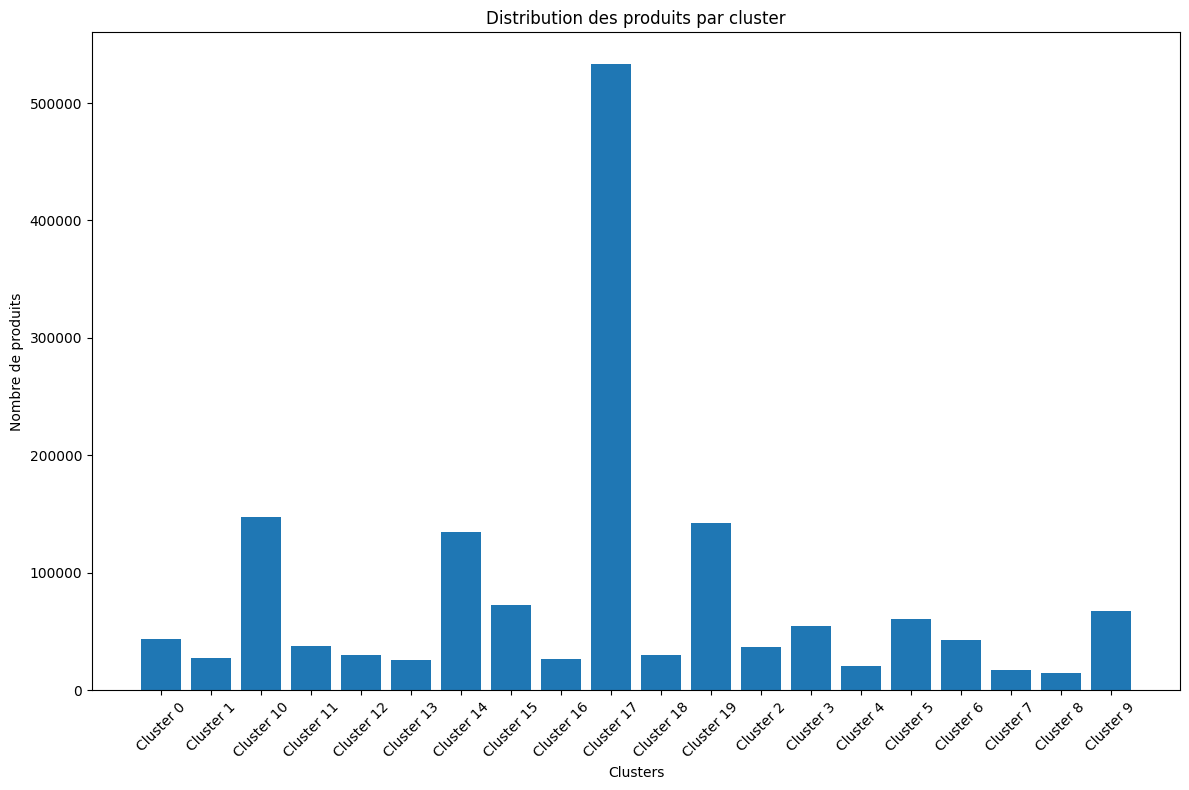

In [5]:
import matplotlib.pyplot as plt

cluster_labels = sorted(df["categories_cluster"].dropna().unique()) #récupérer les labels des clusters
cluster_counts = df["categories_cluster"].value_counts().sort_index() #compter le nombre de produits par cluster

plt.figure(figsize=(12, 8))
plt.bar(range(len(cluster_labels)), cluster_counts)
plt.xticks(range(len(cluster_labels)), cluster_labels, rotation=45)
plt.xlabel('Clusters')
plt.ylabel('Nombre de produits')
plt.title('Distribution des produits par cluster')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'PCA visualization of clusters')

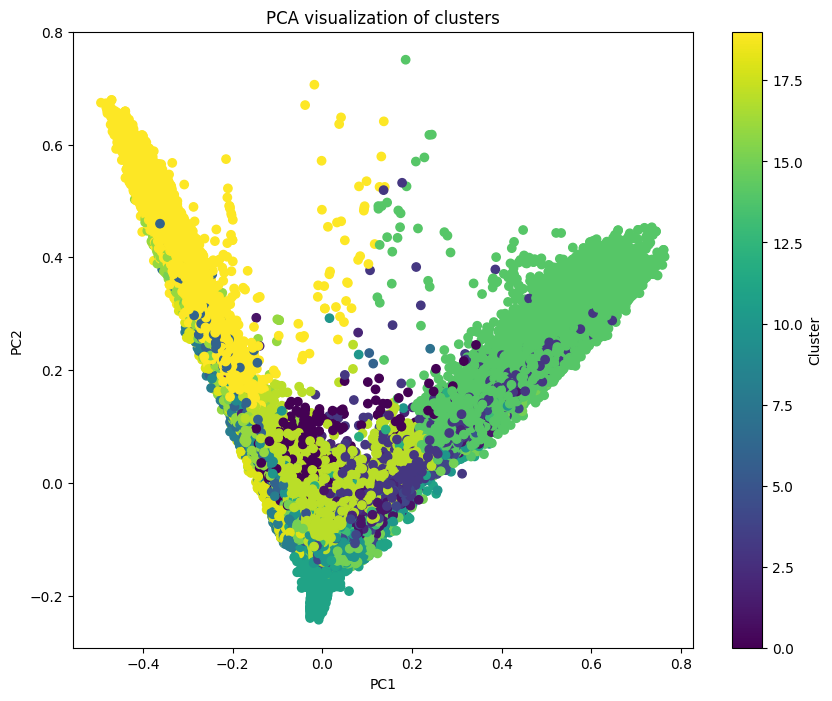

In [6]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2) #réduire la dimension des données à 2
pca.fit(X) #appliquer la PCA sur les données (PCA = réduction de dimension)
X_pca = pca.transform(X) #transformer les données en utilisant la PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_cluster, cmap="viridis")
plt.colorbar(label="Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA visualization of clusters")


Taille de X avant PCA : (254010, 41938)
Taille de X_pca : (50000, 50)
Taille de df_cluster : (254010,)


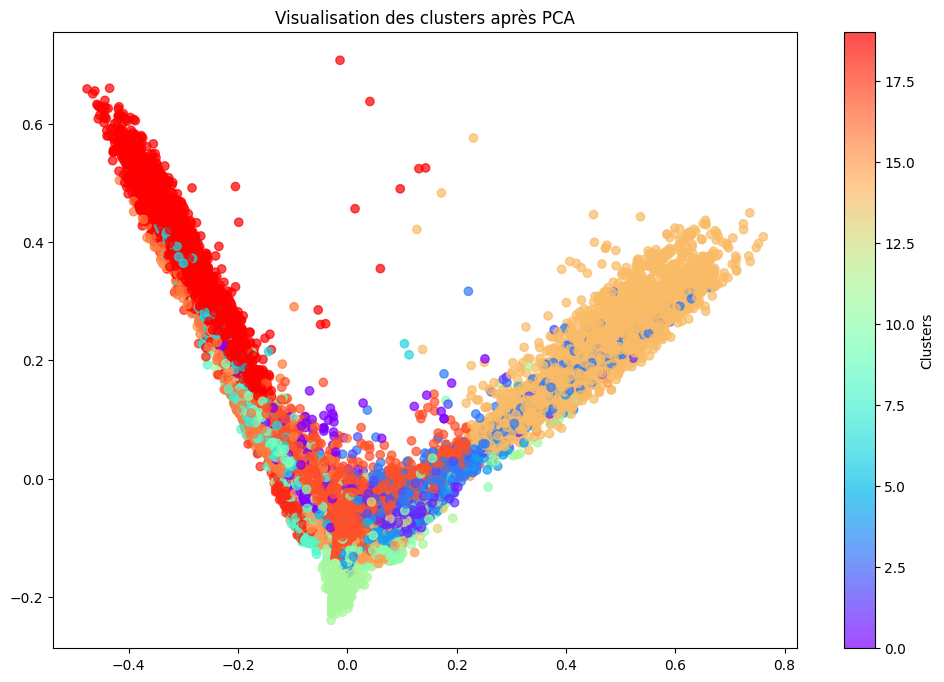

In [7]:
from sklearn.decomposition import IncrementalPCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import issparse

# 1️⃣ Vérifier la taille de X
print("Taille de X avant PCA :", X.shape)

# 2️⃣ Échantillonner X si trop gros
sample_size = 50000  # Ajuster selon la mémoire dispo
indices = np.random.choice(X.shape[0], sample_size, replace=False)

# Vérifier si X est sparse et convertir
X_sample = X[indices].toarray() if issparse(X) else X[indices]

# 3️⃣ Appliquer PCA en mode progressif
pca = IncrementalPCA(n_components=50, batch_size=10000)
X_pca = pca.fit_transform(X_sample)

# 4️⃣ Vérifier la taille de df_cluster
print("Taille de X_pca :", X_pca.shape)
print("Taille de df_cluster :", df_cluster.shape)

# Adapter df_cluster
df_cluster_sample = df_cluster[indices]

# 5️⃣ Visualisation optimisée
plt.figure(figsize=(12,8))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_cluster_sample, cmap="rainbow", alpha=0.7)
plt.colorbar(label="Clusters")
plt.title("Visualisation des clusters après PCA")
plt.show()



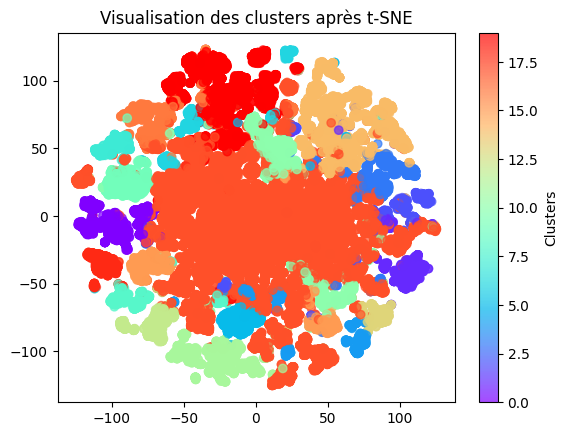

In [8]:
from sklearn.manifold import TSNE  # Plus rapide que sklearn

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_pca)  # Appliquer t-SNE après PCA

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_cluster_sample, cmap="rainbow", alpha=0.7)
plt.title("Visualisation des clusters après t-SNE")
plt.colorbar(label="Clusters")
plt.show()


In [9]:
from sklearn.metrics import silhouette_score

# Calculer le score silhouette
score = silhouette_score(X_pca, df_cluster_sample)
print(f"✅ Score Silhouette : {score:.3f}")


✅ Score Silhouette : 0.329


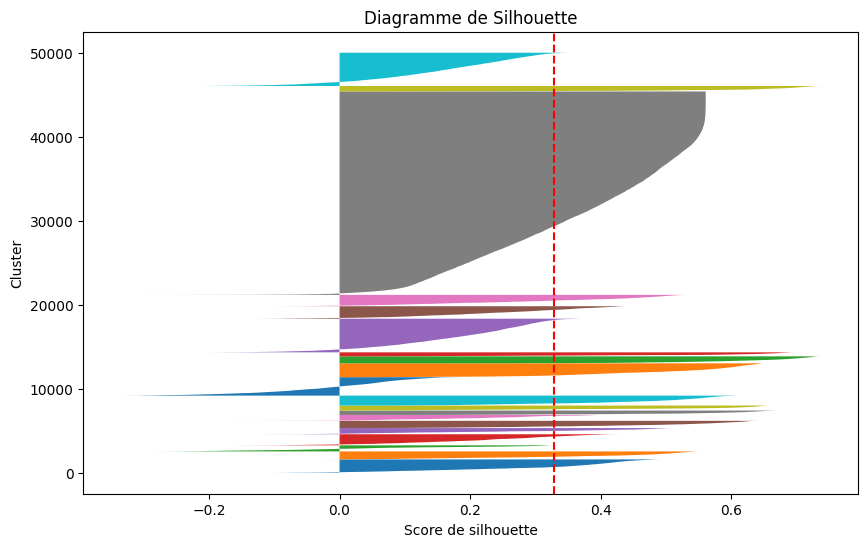

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_samples

# Calcul des coefficients de silhouette
silhouette_vals = silhouette_samples(X_pca, df_cluster_sample)

# Affichage des silhouettes
plt.figure(figsize=(10, 6))
y_ticks = []
y_lower = 0
for i in range(len(set(df_cluster_sample))):
    cluster_silhouette_vals = silhouette_vals[df_cluster_sample == i]
    cluster_silhouette_vals.sort()
    y_upper = y_lower + len(cluster_silhouette_vals)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals)
    y_ticks.append((y_lower + y_upper) / 2)
    y_lower = y_upper

plt.xlabel("Score de silhouette")
plt.ylabel("Cluster")
plt.title("Diagramme de Silhouette")
plt.axvline(x=score, color="red", linestyle="--")  # Score moyen
plt.show()


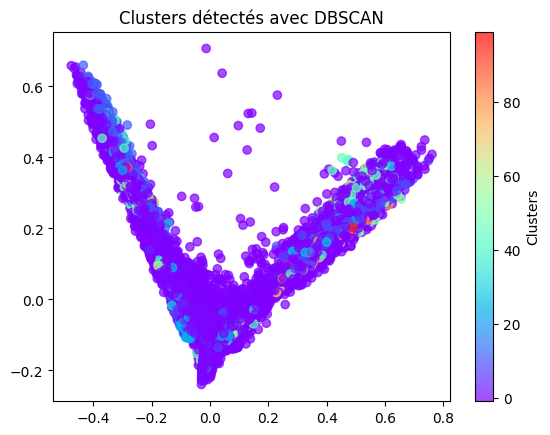

: 

In [22]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.15, min_samples=10).fit(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan.labels_, cmap="rainbow", alpha=0.7)
plt.title("Clusters détectés avec DBSCAN")
plt.colorbar(label="Clusters")
plt.show()
